Matching hankel function to solution to scrodinger equation

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.special import spherical_jn, spherical_yn

Defining hankel functions for solutions outside muffin tin 

$$ u(r)=-i^{l+1}\,r\,h_l(\kappa r) $$


define derivative of $ u(r)$ 

$$ \frac{du}{dr}=-i^{l+1}\left(h_l(\kappa r)+r\,\frac{dh_l(\kappa r)}{dr}\right)$$

In [43]:


def spherical_hankel(l, r,k):

    j = r*spherical_jn(l, r*k)
    y = r*spherical_yn(l, r*k)
    h = -1j*(j + 1j*y)*1j**(l+1)

    dj = r*spherical_jn(l, r*k, derivative=True)*k
    dy = r*spherical_yn(l, r*k, derivative=True)*k
    dh_dx = -1j * (dj + 1j*dy) * (1j**(l+1))

    dh = (h/r + dh_dx)
    return h, dh


define schrodinger ode 

 $$ \left[\frac{h^2}{2m}\frac{d^2}{dr^2}+\left(E-V(r)-\frac{\hbar^2l(l+1)}{2mr^2}\right)\right]u_l(r)=0 $$

 solve in Rydburg units $\frac{\hbar^2}{4m} = 1 \rm {Ry}$

 $$-\,\frac{d^2 u(r)}{dr^2} \;+\; \biggl[ \frac{l(l+1)}{r^2} \;-\;\frac{2Z}{r}\biggr] \,u(r)\;=\;E\,u(r)\,. $$



In [44]:
def potential(r,R):
    """
    Coulomb potential but it can be whatever
    """

    return -2.0 / r + 2.0 / R




In [45]:
def schrod_ode(r, y, E, l,R):
    """
    second order ode to first order
    """
    u, up = y
    # V = -2.0 / r + 2.0 / R

    V= potential(r,R)

    return [up,(l * (l + 1) / r**2 +V- E) * u]

def schrod_int(E, l, boundary_conditions, r_min, R, num_points=3000):

    r_values = np.linspace(r_min, R, num_points)
    sol = solve_ivp(schrod_ode,(r_min, R),boundary_conditions,method='DOP853',t_eval=r_values,args=(E, l,R))
    return r_values, sol.y[0], sol.y[1]

In [46]:
plt.style.use("~/.matplotlib/styles/style.mplstyle")

def residual_match(vars, l, boundary_conditions, r_min, R):

    E, A = vars


    k = np.sqrt(E + 0j)


    r_vals, u_vals, up_vals = schrod_int(E, l, boundary_conditions, r_min, R)
    uR  = u_vals[-1]   # wavefunction at R
    upR = up_vals[-1]  # derivative at R

    h_val, dh_val = spherical_hankel(l,  R,k)

    res1 = (uR- A * h_val).real
    res2 = (upR - A * ( dh_val)).real

    return [res1, res2]

In [47]:
def solver(E_guess, A_guess, l, boundary_conditions, r_min, R):

    x0 = [E_guess, A_guess]
    sol = fsolve(
        residual_match,
        x0,
        args=(l, boundary_conditions, r_min, R),
        xtol=1e-12
    )
    return sol

best E = -0.829122 eV
best A = -29.855781


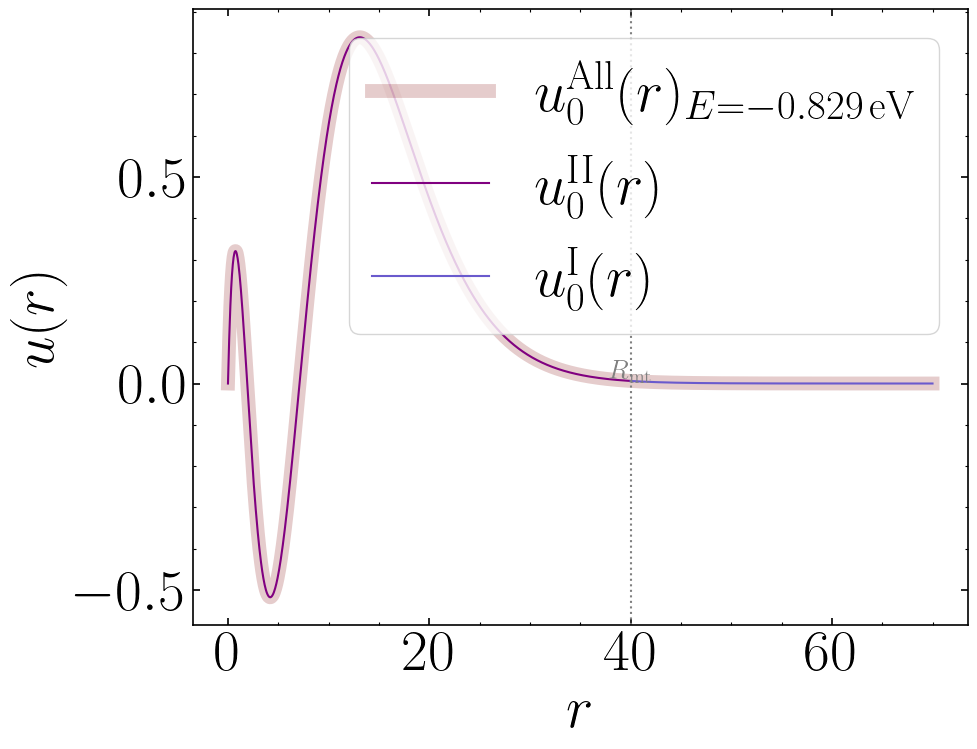

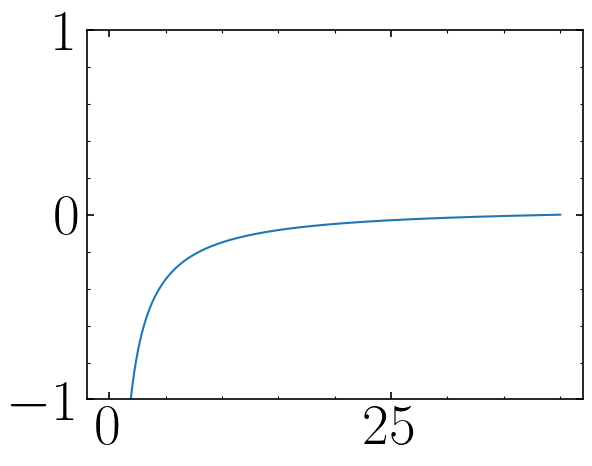

In [48]:
plt.style.use("~/.matplotlib/styles/style.mplstyle")



def plotting(E_best, A_best, l, boundary_conditions, r_min, R,
                           r_extend=80, r_num=1000):
    plt.figure(figsize=(10, 8))
    # Inside solution
    r_in, u_in, up_in = schrod_int(E_best, l, boundary_conditions, r_min, R, r_num)

    # Outside solution
    r_out = np.linspace(R, r_extend, r_num)
    k = np.sqrt(E_best + 0j)
    hankel_vals, _ = spherical_hankel(l, r_out, k)
    hankel_vals = A_best * hankel_vals

    # Combine the radius arrays
    r_full = np.concatenate((r_in, r_out[1:]))  # avoid repeating R
    
    # Combine the corresponding u(r) arrays
    u_full = np.concatenate((u_in, hankel_vals[1:]))

    # Now plot the full solution in black dotted line
    plt.plot(r_full, u_full.real, '-', label=rf"$u_{{{l}}}^{{\rm All}}(r)_{{E={E_best*13.6:.3f}\,\rm eV}}$", linewidth=10, color='maroon', alpha=0.2)
    # If you also want to show them separately:

    plt.plot(r_in,u_in.real,label=fr"$u_{{{l}}}^{{\rm II}}(r)$",color='purple')

    plt.plot(r_out, hankel_vals.real, label=fr"$u_{{{l}}}^{{\rm I}}(r)$",color='slateblue')
    plt.text(R, 0, r'$R_{\rm mt}$', ha='center', va='bottom', color='gray',size=20)
    # plt.ylim(-5, None) 

    plt.axvline(R, color='gray', linestyle=':')

    plt.xlabel(r"$r$")
    plt.ylabel(r"$u(r)$")
    # plt.title(f"(E < 0) (l = {l})")
    plt.legend(loc='upper right')
    plt.savefig("l00.pdf")
    # plt.tight_layout()
    plt.show()

    plt.plot(r_in,potential(r_in,R))
    plt.plot(r_out, [0]*len(r_out))
    plt.ylim(-1,1)
    plt.show()


if __name__ == "__main__":
    l = 0
    bc = [0.0, 1.0]
    r_min = 1e-3
    R = 40
    
    E_guess = -.112
    A_guess = -50.0
    E_best, A_best = solver(E_guess, A_guess, l, bc, r_min, R)

    print(f"best E = {E_best * 13.6:.6f} eV")
    print(f"best A = {A_best:.6f}")

    plotting(E_best, A_best, l, bc, r_min, R, r_extend=70.0)
